In [1]:
import numpy as np
import tensorflow as tf
from collections import deque
import random
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product

# Constants
num_suppliers, num_warehouses, num_products = 2, 2, 2
state_size = (2*2 + 2*2 + 2*2 + 2*2)  # 16
action_size = 12  # Discrete action space
time_horizon = 200
discount_factor = 0.95
stockout_penalty = 100
max_production_capacity = np.full((num_suppliers, num_products), 200).astype(np.float64)
max_transportation_capacity = np.full((num_suppliers, num_warehouses), 100).astype(np.float64)

In [3]:
class SupplyChainEnv:
    def __init__(self):
        self.inventory_buffer = [[deque() for _ in range(num_products)] for _ in range(num_warehouses)]
        self.reset()

    def reset(self):
        self.inventory_buffer = [[deque() for _ in range(num_products)] for _ in range(num_warehouses)]
        self.inventory = np.random.normal(150, 20, (num_warehouses, num_products)).astype(np.float64)
        self.lead_times = np.random.lognormal(2, 0.5, (num_suppliers, num_warehouses)).astype(np.float64)
        self.production_capacities = np.random.uniform(100, 200, (num_suppliers, num_products)).astype(np.float64)
        self.transportation_routes = np.random.uniform(1, 10, (num_suppliers, num_warehouses)).astype(np.float64)
        self.demand = np.random.poisson(60, (num_warehouses, num_products)).astype(np.float64)
        self.step_count = 0
        for w in range(num_warehouses):
            for p in range(num_products):
                self.inventory_buffer[w][p].clear()
        return self._get_state()

    def _get_state(self):
        state = np.concatenate([
            self.inventory.flatten(),
            self.lead_times.flatten(),
            self.production_capacities.flatten(),
            self.transportation_routes.flatten()
        ])
        demand_shock = np.array([1.0 if np.any(self.demand > 80) else 0.0])
        return np.concatenate([state, demand_shock])

    def _action_to_components(self, action_idx):
        order_strategies = ["conservative", "moderate", "aggressive"]
        routing_options = ["fast-switching", "slow-switching"]
        prod_adjustments = [-10, 0, 10]
        
        order_idx = action_idx // (len(routing_options) * len(prod_adjustments))
        routing_idx = (action_idx // len(prod_adjustments)) % len(routing_options)
        prod_idx = action_idx % len(prod_adjustments)
        
        order_qty = np.zeros((num_suppliers, num_warehouses, num_products)).astype(np.float64)
        for s in range(num_suppliers):
            for w in range(num_warehouses):
                for p in range(num_products):
                    if order_strategies[order_idx] == "conservative":
                        order_qty[s, w, p] = np.clip(np.random.normal(50, 5, 1)[0], 0, 100)
                    elif order_strategies[order_idx] == "moderate":
                        order_qty[s, w, p] = np.clip(np.random.normal(75, 5, 1)[0], 0, 100)
                    else:  # aggressive
                        order_qty[s, w, p] = np.clip(np.random.normal(100, 5, 1)[0], 0, 100)
        
        routing = np.array([routing_options[routing_idx]] * num_suppliers * num_warehouses).reshape(num_suppliers, num_warehouses)
        prod_adj = np.array([prod_adjustments[prod_idx]] * num_suppliers)
        
        return order_qty, routing, prod_adj

    def step(self, action_idx):
        order_qty, routing_decisions, prod_adjustments = self._action_to_components(action_idx)
        
        state_obj = State(self.inventory, self.demand, self.lead_times,
                         self.production_capacities, self.transportation_routes)
        action_obj = Action(order_qty, routing_decisions, prod_adjustments)
        
        rewards = compute_reward(state_obj, action_obj, max_production_capacity,
                                max_transportation_capacity, stockout_penalty, self.step_count)
        
        self.production_capacities += prod_adjustments[:, np.newaxis]
        self.production_capacities = np.clip(self.production_capacities, 0, 200).astype(np.float64)
        
        shipped_qty = np.minimum(order_qty, self.production_capacities[:, np.newaxis, :]).astype(np.float64)
        shipped_qty = np.minimum(shipped_qty, max_transportation_capacity[:, :, np.newaxis]).astype(np.float64)
        for s, w, p in product(range(num_suppliers), range(num_warehouses), range(num_products)):
            delay = int(self.lead_times[s, w])
            self.inventory_buffer[w][p].append((shipped_qty[s, w, p], self.step_count + delay))
        
        for w, p in product(range(num_warehouses), range(num_products)):
            arrived = sum(qty for (qty, ts) in self.inventory_buffer[w][p] if ts <= self.step_count)
            self.inventory[w, p] += arrived - self.demand[w, p]
            self.inventory[w, p] = max(self.inventory[w, p], 0)
            self.inventory_buffer[w][p] = deque([(qty, ts) for (qty, ts) in self.inventory_buffer[w][p] if ts > self.step_count])
            self.inventory[w, p] = np.clip(
                self.inventory[w, p] + arrived - self.demand[w, p],
                0, 
                1000  # Add reasonable upper bound
            )
        
        if "slow-switching" in routing_decisions:
            self.lead_times *= 1.2
        self.lead_times = np.clip(self.lead_times, 1, 10).astype(np.float64)
        
        self.step_count += 1
        next_state = self._get_state()
        done = self.step_count >= time_horizon
        return next_state, rewards, done

In [7]:
def compute_reward(state, action, max_production_capacity, max_transportation_capacity, stockout_penalty=100, step_count=None):
    inventory = state.inventory.astype(np.float64)
    demand = state.demand.astype(np.float64)
    lead_times = state.recent_lead_times.astype(np.float64)
    production_capacities = state.production_capacities.astype(np.float64)
    order_qty = action.order_qty.astype(np.float64)
    routing_decisions = action.routing_decisions
    prod_adjustments = action.production_adjustments.astype(np.float64)

    inventory_exp = np.repeat(inventory[np.newaxis, :, :], num_suppliers, axis=0)
    demand_exp = np.repeat(demand[np.newaxis, :, :], num_suppliers, axis=0)

    shipped_qty = np.zeros((num_suppliers, num_warehouses, num_products)).astype(np.float64)
    for s in range(num_suppliers):
        shipped_qty[s] = np.minimum(order_qty[s], production_capacities[s, np.newaxis, :])
        shipped_qty[s] = np.minimum(shipped_qty[s], max_transportation_capacity[s, :, np.newaxis])

    fulfilled_demand = np.minimum(inventory_exp + shipped_qty, demand_exp)
    valid_demand_mask = demand_exp > 0
    service_level = np.zeros_like(demand_exp)
    service_level[valid_demand_mask] = fulfilled_demand[valid_demand_mask] / demand_exp[valid_demand_mask]
    service_level = np.where(demand_exp > 0, fulfilled_demand / demand_exp, 1.0).astype(np.float64)

    ordering_cost = order_qty * 10
    holding_cost = inventory_exp * 1
    unfulfilled = np.maximum(demand_exp - (inventory_exp + shipped_qty), 0)
    stockout_cost = unfulfilled * stockout_penalty
    total_cost = ordering_cost + holding_cost + stockout_cost

    lead_times_exp = np.zeros((num_suppliers, num_warehouses, num_products)).astype(np.float64)
    for s in range(num_suppliers):
        for w in range(num_warehouses):
            for p in range(num_products):
                if routing_decisions[s, w] == "slow-switching":
                    lead_times_exp[s, w, p] = lead_times[s, w] * 1.2
                else:
                    lead_times_exp[s, w, p] = lead_times[s, w]
    lead_times_exp = np.clip(lead_times_exp, 1, 10).astype(np.float64)

    lead_time_variance = np.zeros((num_suppliers, num_warehouses, num_products)).astype(np.float64)
    for s in range(num_suppliers):
        for w in range(num_warehouses):
            for p in range(num_products):
                lead_time_variance[s, w, p] = np.var([lead_times_exp[s, w, p], lead_times[s, w]])

    rewards = np.stack([service_level, total_cost, lead_time_variance], axis=-1).astype(np.float64)
    
    return rewards

In [49]:
def calculate_ttr(env, agent, delta=0.8, perf_metric='service_level'):
    env.step_count = 0
    state = env.reset()
    reward_histories = []
    disruption_time = np.random.randint(20, 80)  # Random timing

    original_demand = env.demand.copy()  # Store original demand
    while env.step_count < time_horizon:
        if env.step_count == disruption_time - 1:
            env.demand *= np.random.uniform(1.3, 2)

        action = agent.act(state)
        next_state, rewards, done = env.step(action)
        
        if rewards is not None and rewards.shape[-1] >= 3:  # Ensure rewards are valid
            reward_histories.append(rewards)

        perf = np.mean(rewards[:, 0]) if perf_metric == 'service_level' else np.mean(rewards)


        if env.step_count > disruption_time:
            if np.mean(rewards[:, 0]) < delta * 0.9:  # Ensure a significant drop before checking recovery
                continue  # Skip until real recovery happens
        
            if np.mean(rewards[:, 0]) >= delta:  # Only count recovery if we were below threshold before
                ttr = env.step_count - disruption_time
                return ttr, reward_histories


        state = next_state

    env.demand = original_demand  # Restore demand if no recovery
    return ttr, reward_histories


In [51]:
def calculate_tta(env, agent, epsilon=0.005, max_steps=150):
    env.step_count = 0
    state = env.reset()
    policy_params_history = []
    steps_since_disruption = 0
    param_diff = float("inf")  # Initialize param_diff
    disruption_time = np.random.randint(20, 80)

    while env.step_count < time_horizon and steps_since_disruption < max_steps:
        action = agent.act(state)
        next_state, rewards, done = env.step(action)
        
        if env.step_count == disruption_time:
            env.demand *= np.random.uniform(1.3, 2)
            env.production_capacities[0] = 0
        
        agent.remember(state, action, rewards, next_state, done)
        agent.replay()

        if env.step_count % agent.update_target_freq == 0:
            agent.update_target()
            params = np.concatenate([w.flatten() for w in agent.model.get_weights()])
            policy_params_history.append(params)

        if env.step_count >= disruption_time:
            steps_since_disruption += 1  # Ensure increment every step after disruption

            if len(policy_params_history) > 5:
                param_diffs = [
                    np.linalg.norm(policy_params_history[-i] - policy_params_history[-(i+1)])
                    for i in range(1, 5)
                ]
                avg_param_diff = np.mean(param_diffs)
                
                # Reduce threshold and ensure significant policy changes
                if avg_param_diff < epsilon * 2 and all(d < epsilon for d in param_diffs[-3:]):
                    return steps_since_disruption, policy_params_history


        state = next_state

    return steps_since_disruption, policy_params_history  # Ensure valid return


In [53]:
def evaluate_maturity_indexes(env, agent, num_runs=2, max_steps=150):
    ttr_values, tta_values, reward_histories = [], [], []
    run_times, perf_swings, converges = [], [], []
    disruption_time = np.random.randint(20, 80)
    for run in tqdm(range(num_runs), desc="Simulation Progress"):
        start_time = time.time()
        
        ttr, rewards_history = calculate_ttr(env, agent)
        ttr_values.append(ttr if ttr is not None else time_horizon)
        perf_swings.append(np.std([np.mean(r[:, 0]) for r in rewards_history][disruption_time:disruption_time+50]))
        run_times.append(time.time() - start_time)
        reward_histories.append(rewards_history)
        
        tta, param_history = calculate_tta(env, agent, max_steps=max_steps)
        tta_values.append(tta if tta is not None else np.nan)
        converges.append(len(param_history) if tta else np.nan)

    pre_disruption_perf = np.mean([np.mean(r[:, 0]) for r in rewards_history][:disruption_time])
    post_disruption_perf = np.mean([np.mean(r[:, 0]) for r in rewards_history][disruption_time:])
    
    stability_robustness = abs(pre_disruption_perf - post_disruption_perf)

    speedup = np.mean(run_times) / np.mean(ttr_values) if np.mean(ttr_values) > 0 else float('inf')
    convergence_rate = np.nanmean(converges) if len(converges) > 0 else np.nan
    adaptability = np.nanmean(tta_values) if len(tta_values) > 0 else np.nan
    gen_ability = np.nanstd(ttr_values) + np.nanstd(tta_values)
    scalability = "Run with increased dims to assess"


    for run in range(num_runs):
        ttr, rewards_history = calculate_ttr(env, agent)
        converges.append(ttr if ttr is not None else np.nan)  # Append NaN instead of failing
    
        tta, param_history = calculate_tta(env, agent, max_steps=max_steps)
        tta_values.append(tta if tta is not None else np.nan)  # Prevent empty list

    
    return {
        "Speedup Performance": speedup,
        "Convergence Rate": convergence_rate,
        "Generalization Ability": gen_ability,
        "Scalability": scalability,
        "Stability and Robustness": stability_robustness,
        "Adaptability": adaptability,
        "TTR Values": ttr_values,
        "TTA Values": tta_values,
        "Reward Histories": reward_histories
    }

In [35]:
class DQNAgent:
    def __init__(self):
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.memory = deque(maxlen=1000)
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.batch_size = 32
        self.update_target_freq = 5

    def _build_model(self):
        input_layer = tf.keras.layers.Input(shape=(state_size + 1,))
        shared_features = tf.keras.layers.Dense(64, activation='relu')(input_layer)
        shared_features = tf.keras.layers.Dense(32, activation='relu')(shared_features)

        q_values = tf.keras.layers.Dense(action_size, activation='linear', name='q_values')(shared_features)
        order_logits = tf.keras.layers.Dense(3, name='order_logits')(shared_features)
        order_policy = tf.keras.layers.Softmax(name='order_policy')(order_logits)
        route_logits = tf.keras.layers.Dense(2, name='route_logits')(shared_features)
        route_policy = tf.keras.layers.Lambda(
            lambda x: self._gumbel_softmax(x, tau=1.0, hard=True),
            name='route_policy'
        )(route_logits)
        prod_mean = tf.keras.layers.Dense(1, name='prod_mean')(shared_features)  # Only 1 output
        prod_log_std = tf.keras.layers.Dense(1, activation='softplus', name='prod_log_std')(shared_features)
        prod_policy = tf.keras.layers.Lambda(lambda x: self.sample_gaussian(x[0], x[1]), 
                                           name='prod_policy')([prod_mean, prod_log_std])
        
        model = tf.keras.Model(inputs=input_layer, outputs=[q_values, order_policy, route_policy, prod_policy])
        
        #y_pred[1] = tf.keras.utils.to_categorical(y_pred[1], num_classes=3)
        #y_pred[2] = tf.keras.utils.to_categorical(y_pred[2], num_classes=2)

        def custom_loss(y_true, y_pred):
            q_loss = tf.keras.losses.MSE(y_true[0], y_pred[0])
            if y_pred[1].shape[-1] == 1:  # Binary classification
                order_loss = tf.keras.losses.binary_crossentropy(y_true[1], y_pred[1])
            else:  # Multi-class classification
                order_loss = tf.keras.losses.categorical_crossentropy(y_true[1], y_pred[1])
            if y_pred[2].shape[-1] == 1:  # Binary classification
                route_loss = tf.keras.losses.binary_crossentropy(y_true[2], y_pred[2])
            else:  # Multi-class classification
                route_loss = tf.keras.losses.categorical_crossentropy(y_true[2], y_pred[2])



            prod_loss = tf.keras.losses.MSE(tf.expand_dims(y_true[3], -1), y_pred[3])  # Add dimension
            return q_loss + 0.5 * (order_loss + route_loss + prod_loss)
        
        model.compile(optimizer='adam', loss=custom_loss)
        return model

    def _gumbel_softmax(self, logits, tau=1.0, hard=True):
        gumbel_noise = -tf.math.log(-tf.math.log(tf.random.uniform(tf.shape(logits), minval=1e-10, maxval=1.0)))
        y = logits + gumbel_noise
        y = tf.nn.softmax(y / tau, axis=-1)
        if hard:
            y_hard = tf.cast(tf.equal(y, tf.reduce_max(y, axis=-1, keepdims=True)), y.dtype)
            y = tf.stop_gradient(y_hard - y) + y
        return y

    def sample_gaussian(self, mean, log_std):
        std = tf.exp(log_std)
        noise = tf.random.normal(tf.shape(mean), mean=0.0, stddev=1.0)
        return mean + std * noise

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(action_size)
        
        q_values, order_policy, route_policy, prod_policy = self.model.predict(state[np.newaxis, :], verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        if isinstance(reward, np.ndarray) and reward.shape == (8, 3):
            agg_reward = np.mean(reward)
        else:
            agg_reward = 0.0
            #print(f"Warning: Unexpected reward type or shape in remember: {reward}, using {agg_reward}")
        
        order_idx = action // (2 * 3)  # 2 routing options, 3 prod adjustments
        route_idx = (action // 3) % 2
        prod_idx = action % 3
        
        order_true = tf.keras.utils.to_categorical(order_idx, num_classes=3)  # Shape: (3,)
        route_true = tf.keras.utils.to_categorical(route_idx, num_classes=2)  # Shape: (2,)
        prod_true = np.array([-10, 0, 10])[prod_idx].astype(np.float32)  # Scalar value
        
        self.memory.append((state, action, agg_reward, next_state, done, order_true, route_true, prod_true))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones, order_trues, route_trues, prod_trues = zip(*batch)
        
        states = np.array(states)           # Shape: (batch_size, state_size + 1)
        next_states = np.array(next_states) # Shape: (batch_size, state_size + 1)
        rewards = np.array(rewards)         # Shape: (batch_size,)
        actions = np.array(actions)         # Shape: (batch_size,)
        dones = np.array(dones)             # Shape: (batch_size,)
        order_trues = np.array(order_trues) # Shape: (batch_size, 3)
        route_trues = np.array(route_trues) # Shape: (batch_size, 2)
        prod_trues = np.array(prod_trues)   # Shape: (batch_size,)
        
        # Ensure prod_trues is 2D for MSE (batch_size, 1)
        prod_trues = prod_trues.reshape(-1, 1)
        
        current_q = self.model.predict(states, verbose=0)[0]  # Shape: (batch_size, action_size)
        next_q = self.target_model.predict(next_states, verbose=0)[0]  # Shape: (batch_size, action_size)
        targets = np.copy(current_q)
        
        for i in range(self.batch_size):
            target = rewards[i] + (1 - dones[i]) * discount_factor * np.max(next_q[i])
            targets[i, actions[i]] = target
        
        # Verify shapes before fitting
        #print(f"targets shape: {targets.shape}, order_trues shape: {order_trues.shape}, route_trues shape: {route_trues.shape}, prod_trues shape: {prod_trues.shape}")
        
        self.model.fit(states, [targets, order_trues, route_trues, prod_trues], epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            #print(f"Epsilon: {self.epsilon:.3f}")

    def update_target(self):
        self.target_model.set_weights(self.model.get_weights())

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reward_components(reward_histories, disruption_time=10, ttr=None, tta=None, delta=0.8):
    if not reward_histories or len(reward_histories) == 0:
        print("Warning: No valid reward data to plot.")
        return

    # Ensure all entries in reward_histories have the expected shape (N, 3)
    filtered_rewards = []
    for r in reward_histories:
        if isinstance(r, np.ndarray):
            if r.ndim > 2:  # Flatten if too many dimensions
                r = r.reshape(-1, r.shape[-1])
            if r.shape[-1] == 3:  # Ensure it has 3 reward components
                filtered_rewards.append(r)
    
    if len(filtered_rewards) == 0:
        print("Warning: No valid reward data to plot after filtering.")
        return
    
    # Extract performance metrics from filtered reward histories
    service_level = [np.mean(r[:, 0]) for r in filtered_rewards]
    total_cost = [np.mean(r[:, 1]) for r in filtered_rewards]
    lead_time_variance = [np.mean(r[:, 2]) for r in filtered_rewards]

    time_steps = np.arange(len(filtered_rewards))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # Plot Service Level
    ax1.plot(time_steps, service_level, label='Service Level', color='blue')
    ax1.axvline(x=disruption_time, color='red', linestyle='--', label='Disruption')
    if ttr is not None: ax1.axvline(x=disruption_time + ttr, color='green', linestyle='--', label='TTR')
    if tta is not None: ax1.axvline(x=disruption_time + tta, color='blue', linestyle='--', label='TTA')
    ax1.axhline(y=delta, color='gray', linestyle=':', label=f'Threshold (δ={delta})')
    ax1.set_title('Service Level')
    ax1.set_ylabel('Service Level')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True)

    # Plot Total Cost
    ax2.plot(time_steps, total_cost, label='Total Cost', color='red')
    ax2.axvline(x=disruption_time, color='red', linestyle='--', label='Disruption')
    if ttr is not None: ax2.axvline(x=disruption_time + ttr, color='green', linestyle='--', label='TTR')
    if tta is not None: ax2.axvline(x=disruption_time + tta, color='blue', linestyle='--', label='TTA')
    ax2.set_title('Total Cost')
    ax2.set_ylabel('Total Cost')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True)

    # Plot Lead Time Variance
    ax3.plot(time_steps, lead_time_variance, label='Lead Time Variance', color='green')
    ax3.axvline(x=disruption_time, color='red', linestyle='--', label='Disruption')
    if ttr is not None: ax3.axvline(x=disruption_time + ttr, color='green', linestyle='--', label='TTR')
    if tta is not None: ax3.axvline(x=disruption_time + tta, color='blue', linestyle='--', label='TTA')
    ax3.set_title('Lead Time Variance')
    ax3.set_xlabel('Time Steps')
    ax3.set_ylabel('Variance')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True)

    plt.suptitle('Supply Chain Reward Components')
    plt.tight_layout()
    plt.show()


In [ ]:
class State:
    def __init__(self, inventory_levels, demand, lead_times, production_capacities, transportation_routes):
        self.inventory = inventory_levels.astype(np.float64)
        self.demand = demand.astype(np.float64)
        self.recent_lead_times = lead_times.astype(np.float64)
        self.production_capacities = production_capacities.astype(np.float64)
        self.transportation_routes = transportation_routes.astype(np.float64)

class Action:
    def __init__(self, order_quantities, routing_decisions, production_adjustments):
        self.order_qty = order_quantities.astype(np.float64)
        self.routing_decisions = routing_decisions
        self.production_adjustments = production_adjustments.astype(np.float64)

# Run simulation and plot
env = SupplyChainEnv()
agent = DQNAgent()
metrics = evaluate_maturity_indexes(env, agent)

reward_histories = metrics["Reward Histories"][0]
ttr = metrics["TTR Values"][0] if metrics["TTR Values"][0] != time_horizon else None
max_steps = 100
tta = metrics["TTA Values"][0] if metrics["TTA Values"][0] != max_steps else None

plot_reward_components(reward_histories, disruption_time=10, ttr=ttr, tta=tta, delta=0.8)
print("Maturity Indexes:", metrics)

Simulation Progress:   0%|                                                                       | 0/2 [00:00<?, ?it/s]

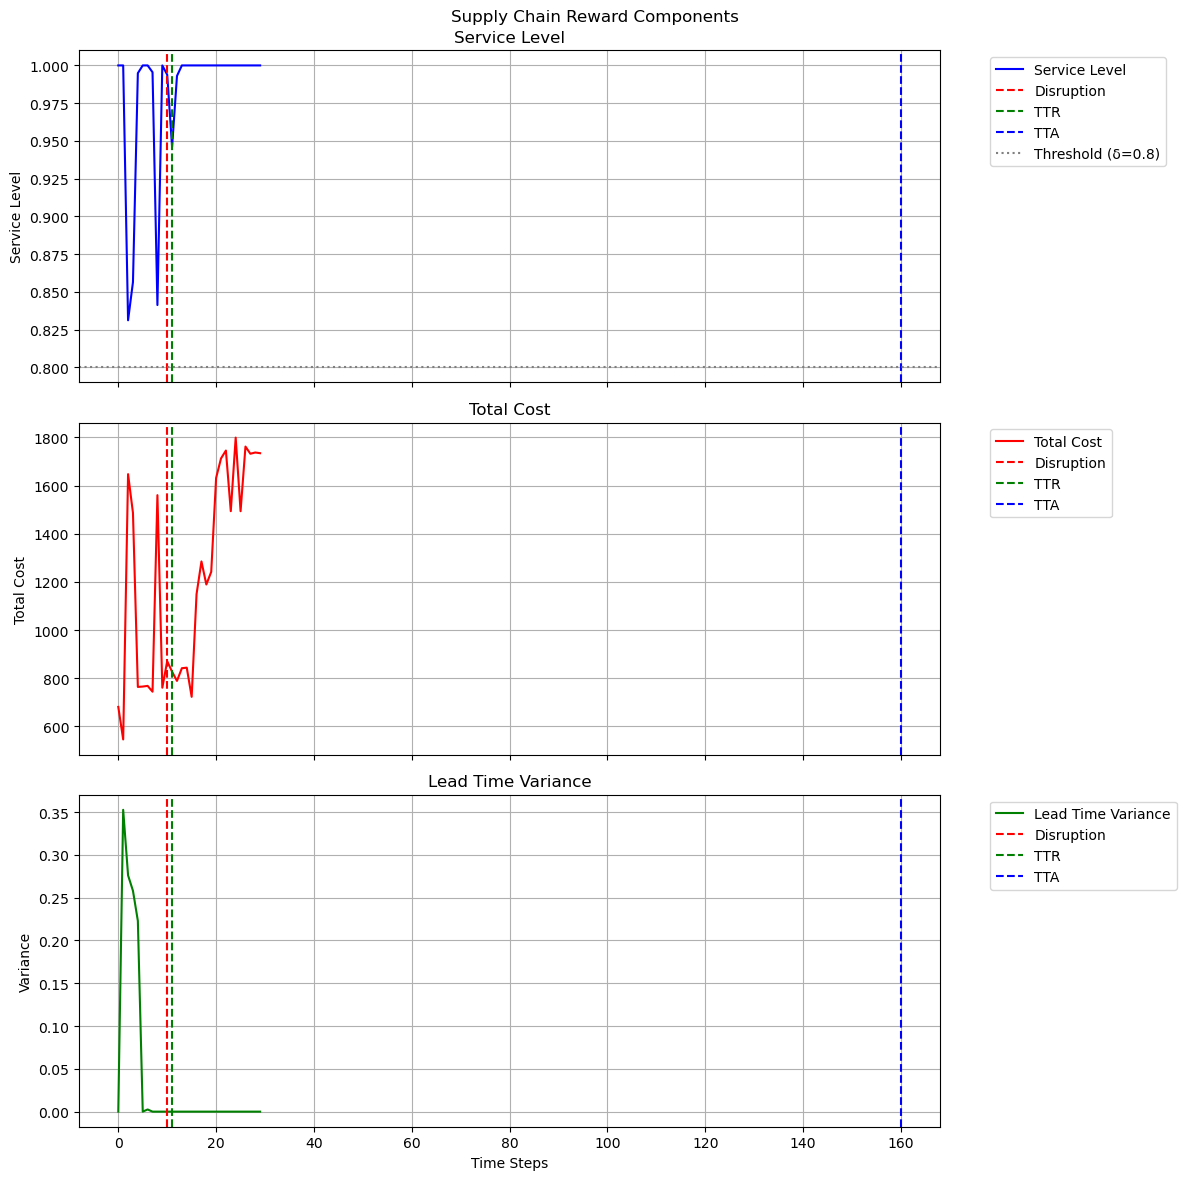

Maturity Indexes: {'Speedup Performance': 1.9265214204788208, 'Convergence Rate': 40.0, 'Generalization Ability': 0.0, 'Scalability': 'Run with increased dims to assess', 'Stability and Robustness': nan, 'Adaptability': 150.0, 'TTR Values': [1, 1], 'TTA Values': [150, 150, 150, 150], 'Reward Histories': [[array([[[[  1.        , 625.6420606 ,   0.        ],
         [  1.        , 668.70033458,   0.        ]],

        [[  1.        , 691.23658718,   0.        ],
         [  1.        , 644.2364315 ,   0.        ]]],


       [[[  1.        , 542.61892836,   0.        ],
         [  1.        , 695.08431107,   0.        ]],

        [[  1.        , 744.17258838,   0.        ],
         [  1.        , 837.7998037 ,   0.        ]]]]), array([[[[1.00000000e+00, 5.65620322e+02, 3.80453065e-01],
         [1.00000000e+00, 6.23044228e+02, 3.80453065e-01]],

        [[1.00000000e+00, 5.03354299e+02, 5.32290683e-01],
         [1.00000000e+00, 5.79662098e+02, 5.32290683e-01]]],


       [[[1.000

In [47]:
reward_histories = metrics["Reward Histories"][0]
ttr = metrics["TTR Values"][0] if metrics["TTR Values"][0] != time_horizon else None
max_steps = 100
tta = metrics["TTA Values"][0] if metrics["TTA Values"][0] != max_steps else None

plot_reward_components(reward_histories, disruption_time=10, ttr=ttr, tta=tta, delta=0.8)
print("Maturity Indexes:", metrics)